# Importing Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Library Imports

In [24]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import kpss
# import pandoc
# import pmdarima

ModuleNotFoundError: ignored

# Reading Data

## Reading train and test data

In [4]:
df = pd.read_csv("/content/drive/MyDrive/ML Project /Time Series Analysis/Data/train.csv")
df["date"] = pd.to_datetime(df['date'], format='%Y-%m-%d') # formatting the date

In [5]:
df_test = pd.read_csv("/content/drive/MyDrive/ML Project /Time Series Analysis/Data/test.csv")
df_test["date"] = pd.to_datetime(df_test['date'], format='%Y-%m-%d') # formatting the date

In [6]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [7]:
df_final = pd.DataFrame(columns=['id','date','store_nbr','family','onpromotion','pred'])

## Reading store data

In [8]:
df_stores = pd.read_csv('/content/drive/MyDrive/ML Project /Time Series Analysis/Data/stores.csv')

In [9]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


# Creating Combination of store number, cluster & product family

In [10]:
#Fetching list of unique products and store numbers
family_list = df['family'].unique().tolist()
store_list = df['store_nbr'].unique().tolist()

In [11]:
comb_store_family = list(itertools.product(store_list, family_list))
len(comb_store_family)

1782

# Merging of store numbers with their respective cluster

In [12]:
df_merge = pd.merge(df, df_stores[['store_nbr','cluster']], how='left', on='store_nbr')

In [13]:
df_merge.head()

,id,date,store_nbr,family,sales,onpromotion,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,13
1,1,2013-01-01,1,BABY CARE,0.0,0,13
2,2,2013-01-01,1,BEAUTY,0.0,0,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,13
4,4,2013-01-01,1,BOOKS,0.0,0,13


# Checking lags using PACF

In [14]:
family_list

['AUTOMOTIVE',
 'BABY CARE',
 'BEAUTY',
 'BEVERAGES',
 'BOOKS',
 'BREAD/BAKERY',
 'CELEBRATION',
 'CLEANING',
 'DAIRY',
 'DELI',
 'EGGS',
 'FROZEN FOODS',
 'GROCERY I',
 'GROCERY II',
 'HARDWARE',
 'HOME AND KITCHEN I',
 'HOME AND KITCHEN II',
 'HOME APPLIANCES',
 'HOME CARE',
 'LADIESWEAR',
 'LAWN AND GARDEN',
 'LINGERIE',
 'LIQUOR,WINE,BEER',
 'MAGAZINES',
 'MEATS',
 'PERSONAL CARE',
 'PET SUPPLIES',
 'PLAYERS AND ELECTRONICS',
 'POULTRY',
 'PREPARED FOODS',
 'PRODUCE',
 'SCHOOL AND OFFICE SUPPLIES',
 'SEAFOOD']

In [15]:
cluster_mapping = df_merge[['store_nbr',"cluster","family"]].groupby(['store_nbr',"cluster","family"]).count().reset_index()

In [16]:
cluster_mapping.head()

,store_nbr,cluster,family
0,1,13,AUTOMOTIVE
1,1,13,BABY CARE
2,1,13,BEAUTY
3,1,13,BEVERAGES
4,1,13,BOOKS


In [17]:
cluster_mapping[cluster_mapping["cluster"]==1]["store_nbr"].unique()

array([24, 25, 27])

P-value:  2.030771497359445e-06


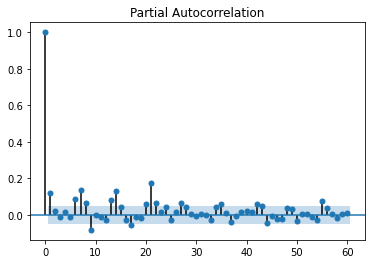

In [18]:
#providing custom inputs
df_temp = df_merge[(df_merge['store_nbr']==51)&(df_merge['family']=="AUTOMOTIVE")&(df_merge['cluster']==17)]
df_stationarityTest = adfuller(df_temp['sales'].values, autolag='AIC')
print("P-value: ", df_stationarityTest[1])
pacf = plot_pacf(df_temp['sales'].values, lags=60) #change "lags" according to convienience

In [19]:
#fetching every row in list
list_df = cluster_mapping.values.tolist()

In [20]:
#average lags per cluster
cluster_lag_map = {1:14,2:18,3:8,4:13,5:14,6:7,7:10,8:10,9:15,10:9,11:7,12:14,13:21,14:8,15:9,16:8,17:7}

In [21]:
df_merge.shape

(3000888, 7)

# Checking difference lags

In [ ]:
list_p_value = []
for i in list_df:
  df_temp = df_merge[(df_merge['store_nbr']==i[0])&(df_merge['family']==i[2])].reset_index(drop = True)
  df_stationarityTest = adfuller(df_temp['sales'].values, autolag='AIC')
  if df_stationarityTest[1] > 0.05:
    i.append(1)
  else:
    i.append(0)
  list_p_value.append(i)


# Modeling AR

In [ ]:
cluster_lag_map_MA = {1:20,2:12,3:7,4:19,5:8,6:6,7:13,8:20,9:14,10:6,11:21,12:8,13:29,14:28,15:5,16:7,17:8}

In [ ]:
for i in list_df:
  print("NEW ITERATION")
  print(i)
  df_temp = df_merge[(df_merge['store_nbr']==i[0])&(df_merge['family']==i[2])].reset_index(drop = True)
  df_temp["sales"] = np.log(df_temp["sales"]) #logarithmic normalization
  df_temp = df_temp.fillna(0) #filling null values
  df_temp = df_temp.replace([np.inf, -np.inf], 0) #filling values when log(0) takes place which cannot be computed
  df_test_temp =  df_test[(df_test['store_nbr']==i[0])&(df_test['family']==i[2])].reset_index(drop = True)
  if len(df_test_temp)>0:
    arima_model = ARIMA(df_temp["sales"], order=(0,i[3],0)).fit(disp=0) #fitting the model
    df_test_temp["sales"] = np.exp(arima_model.forecast(df_test_temp.shape[0],alpha=0.05)[0])
    df_final = pd.concat([df_final, df_test_temp])

## Joining test set with predict to submission file based on id column

In [ ]:
df_sample = pd.read_csv("/content/drive/MyDrive/ML Project /Time Series Analysis/Data/sample_submission.csv")
# df_sample["sales"] = df_final["pred"].values
df_sample_final = pd.merge(df_sample[['id']], df_final[['id','sales']], how='left', on='id')
df_sample_final.head()

,id,sales
0,3000888,3.494406
1,3000888,3.494406
2,3000888,2.568781
3,3000889,1.000000
4,3000890,2.076909


In [ ]:
df_sample_final.to_csv("/content/drive/MyDrive/ML Project /Time Series Analysis/Submission files/ARIMA_model_sub.csv",index=True)